# Approach based on density maps generation

In [1]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as data
#from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
# Torchvision library
import torchvision
import torch.nn as nn
from tqdm import tqdm # plot progress bars
import numpy as np

import os
import pandas as pd
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import copy
import cv2
import random
import time

from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)


## Data adquisition  definition of the Dataset class and Dataloader

In [3]:
class CustomImageDataset(Dataset):
    """As builsing back the images to the original size is usefull for counting the number of kernels
       I need to pass this information """
    def __init__(self, annotations_file, img_dir,scale, img_transform=None, target_transform=None,geo_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir    = img_dir
        ### Transforms
        self.geo_transform    = geo_transform
        self.img_transform    = img_transform
        self.target_transform = target_transform
        self.scale = scale

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # I load it as a PIL image so I can perform some transforms that are not available for tensors.
        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        label    = cv2.imread(label_path,flags=cv2.IMREAD_ANYDEPTH)
        label *= self.scale
        shape = label.shape
        count = self.img_labels.iloc[idx, 1]
        

        if self.img_transform:
            image = self.img_transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.geo_transform:
            image = self.geo_transform(image)
            label = self.geo_transform(label)                    
        return image, label, shape, count
    

In [4]:
### Define transforms
geometric_transforms = transforms.Compose([transforms.RandomRotation(15),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomVerticalFlip(p=0.5),
                                          ])


train_transforms = transforms.Compose([
                                        torchvision.transforms.ColorJitter(),
                                        torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                                        transforms.ToTensor(),
                                        transforms.Resize((224,224)),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        ])

# The test dataset must remain as original as possible
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224)),
                                     ])

target_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224)),]) 

In [5]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

dataset = "corn"

train_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_train_labels.csv" 
train_data_path = path + f"{dataset}_coco/train_set" 

test_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_test_labels.csv" 
test_data_path = path + f"{dataset}_coco/test_set"


In [6]:
### Define dataset
scale = 1e4
train_dataset = CustomImageDataset(train_csv_path, train_data_path,
                                   scale = scale,
                                   img_transform=train_transforms,
                                   target_transform = target_transform,
                                   geo_transform = geometric_transforms)

test_dataset = CustomImageDataset(test_csv_path, test_data_path,
                                  scale = scale,
                                  img_transform = test_transforms,
                                  target_transform = target_transform)

In [7]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.80)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 193


In [8]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 193
Number validation examples: 49
Number test examples: 62


In [9]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set
validation_dataset.dataset.transform = test_transforms

In [10]:
# data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Lets check if dataloaders are working properly

In [11]:
start_time = time.time()
train_features, train_labels, shape,count = next(iter(train_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 3.82 s


In [12]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

UP = nn.Upsample(size=(shape[0][0],shape[1][0]),mode='bilinear')
img = train_features[0]#.numpy().transpose(1, 2, 0)
img = img[None, :]
img = UP(img)
img = img[0].numpy().transpose(1, 2, 0)

label = train_labels[0]#.numpy().transpose(1, 2, 0)
label = label[None, :]
label = UP(label)
label = label[0].numpy().transpose(1, 2, 0)

print(f"Feature batch shape: {img.shape}")
print(f"Labels batch shape: {label.shape}")

Feature batch shape: torch.Size([50, 3, 224, 224])
Labels batch shape: torch.Size([50, 1, 224, 224])
Feature batch shape: (2309, 1732, 3)
Labels batch shape: (2309, 1732, 1)


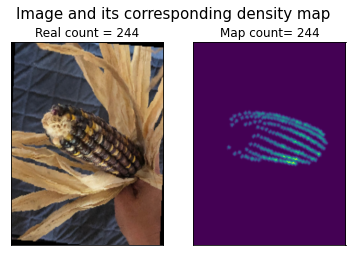

In [13]:
# Display image and label.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Image and its corresponding density map",fontsize=15)
ax1.imshow(img)
ax1.set_title(f"Real count = {count[0]}",fontsize=12)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(label)
ax2.set_title(f"Map count= {int(label.sum()/1e4)}", fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

# Network architecture

In [14]:
class Map_CNN(nn.Module):
    def __init__(self, Pre_Trained_Encoder):
        super().__init__()
        
        self.encoder     = Pre_Trained_Encoder
         ### Encoder
        self.decoder = nn.Sequential(  
                       nn.Conv2d(in_channels  = 512,      # C1
                                  out_channels = 256,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),                    
                        nn.Conv2d(in_channels  = 256,     # C2    
                                  out_channels = 128,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True), 
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 128,     #C3  
                                  out_channels = 64,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 64,      #C4  
                                  out_channels = 1,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 1,       #C5
                                  out_channels = 1,
                                  kernel_size  = 1,
                                  padding = 0,
                                  stride = 1)
            )
        
    def forward(self, x,mode):
        if (mode == "Train"):
            self.encoder.train()
            self.decoder.train()
        elif (mode == "Test"):
            self.encoder.eval()
            self.decoder.eval()
        y = self.encoder(x)
        y = self.decoder(y)
        return y
    
    
    def train_epoch(self,device,dataloader, loss_fn, optimizer):
        """
        This function train the network for one epoch
        """
        # Train
        loss_list = []
        for x, y,_,_ in dataloader:
            # Move data to device
            x = x.to(device)
            y = y.to(device)
            # Forward
            y_pred = self.forward(x,"Train")
            # Compute loss
            loss = loss_fn(y_pred, y)
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            # Save batch loss
            loss_list.append(loss.detach().cpu().numpy())
        return np.mean(loss_list)

    def validate_epoch(self,device, dataloader, loss_fn):
        """
        This function validate/test the network performance for one epoch of training
        """
        loss_list = []
        # Discable gradient tracking
        with torch.no_grad():
            for x, y,_,_ in dataloader:
                x = x.to(device)
                y = y.to(device)
                y_pred = self.forward(x,"Test")
                loss = loss_fn(y_pred, y)
                loss_list.append(loss.detach().cpu().numpy()) 
        return np.mean(loss_list)
       
    def training_cycle(self, device, training_iterator, test_iterator, loss_fn, optim, num_epochs,
                       verbose= True):
        """
        This function train the network for a desired number of epochs it also test the network 
        reconstruction performance and make plots comparing the input image and the reconstructed one every 5 epochs.
        """
        #initialize the tensorboard writer
        #writer = SummaryWriter()
        #I keep track of losses for plots
        train_loss = []
        val_loss  = []
        for epoch in tqdm(range(num_epochs)):
            start_time = time.time()
            ### Training (use the training function)
            tr_l = self.train_epoch(device=device, 
                                    dataloader=training_iterator, 
                                    loss_fn=loss_fn, 
                                    optimizer=optim)
            train_loss.append(tr_l)
            writer.add_scalar("Loss/train", tr_l, epoch)
            
            ### Validation  (use the testing function)
            v_l = self.validate_epoch(device=device, 
                                      dataloader=test_iterator, 
                                      loss_fn=loss_fn)
            val_loss.append(v_l)
            writer.add_scalar("Loss/validation", v_l, epoch)
            end_time = time.time()
            writer.flush()
            if verbose:
                print(f"\nEpoch: {epoch+1}/{num_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
                print("---------------------------------")
                print(f"Train -- Loss: {tr_l:.3f}")
                print(f"Val -- Loss: {v_l:.3f}")
        return train_loss, val_loss
    

Prepare pre trained model for backbone and define our model

In [15]:
### Load pretrained model
VGG16 = smp.Unet('vgg16', encoder_weights='imagenet')
### Load weights
#VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))
### Define the encoder
backbone = VGG16.encoder.features[0:20]
### Define the model
model = Map_CNN(backbone)

In [16]:
# ### Load pretrained model
# VGG16 = torchvision.models.vgg16(pretrained = True)
# ### Load weights
# #VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))
# ### Define the encoder
# enc = VGG16.features[0:20]
# ### Define the model
# model = Map_CNN(enc)

In [17]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in model.named_parameters():
    print(param_name,param.requires_grad)

encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
encoder.5.weight False
encoder.5.bias False
encoder.7.weight False
encoder.7.bias False
encoder.10.weight False
encoder.10.bias False
encoder.12.weight False
encoder.12.bias False
encoder.14.weight False
encoder.14.bias False
encoder.17.weight False
encoder.17.bias False
encoder.19.weight False
encoder.19.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True
decoder.5.weight True
decoder.5.bias True
decoder.8.weight True
decoder.8.bias True
decoder.11.weight True
decoder.11.bias True


In [18]:
max_epochs        = 250
learning_rate     = 1e-3

In [19]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


Map_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [20]:
writer = SummaryWriter(f"./runs/only_geometric_augmentation_lr_{learning_rate}_epochs_{max_epochs}_scale_{scale}2")
train_loss, test_loss = model.training_cycle(device,
                                train_dataloader,
                                validation_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                verbose=True)
### To end TensorBoard writings
writer.close()

  0%|▎                                                                               | 1/250 [01:05<4:32:59, 65.78s/it]


Epoch: 1/250 -- Epoch Time: 65.78 s
---------------------------------
Train -- Loss: 601.632
Val -- Loss: 394.547


  1%|▋                                                                               | 2/250 [02:13<4:35:58, 66.77s/it]


Epoch: 2/250 -- Epoch Time: 67.46 s
---------------------------------
Train -- Loss: 555.694
Val -- Loss: 372.029


  1%|▉                                                                               | 3/250 [03:35<5:03:31, 73.73s/it]


Epoch: 3/250 -- Epoch Time: 82.01 s
---------------------------------
Train -- Loss: 567.084
Val -- Loss: 366.069


  2%|█▎                                                                              | 4/250 [05:02<5:24:17, 79.10s/it]


Epoch: 4/250 -- Epoch Time: 87.32 s
---------------------------------
Train -- Loss: 530.952
Val -- Loss: 356.027


  2%|█▌                                                                              | 5/250 [06:30<5:36:00, 82.29s/it]


Epoch: 5/250 -- Epoch Time: 87.94 s
---------------------------------
Train -- Loss: 523.740
Val -- Loss: 341.277


  2%|█▉                                                                              | 6/250 [07:56<5:39:47, 83.56s/it]


Epoch: 6/250 -- Epoch Time: 86.02 s
---------------------------------
Train -- Loss: 500.528
Val -- Loss: 317.989


  3%|██▏                                                                             | 7/250 [09:22<5:41:23, 84.29s/it]


Epoch: 7/250 -- Epoch Time: 85.81 s
---------------------------------
Train -- Loss: 456.242
Val -- Loss: 270.403


  3%|██▌                                                                             | 8/250 [10:50<5:44:42, 85.46s/it]


Epoch: 8/250 -- Epoch Time: 87.96 s
---------------------------------
Train -- Loss: 358.714
Val -- Loss: 220.590


  4%|██▉                                                                             | 9/250 [12:16<5:44:30, 85.77s/it]


Epoch: 9/250 -- Epoch Time: 86.44 s
---------------------------------
Train -- Loss: 310.983
Val -- Loss: 201.345


  4%|███▏                                                                           | 10/250 [13:43<5:44:17, 86.07s/it]


Epoch: 10/250 -- Epoch Time: 86.75 s
---------------------------------
Train -- Loss: 293.364
Val -- Loss: 179.299


  4%|███▍                                                                           | 11/250 [15:10<5:44:10, 86.41s/it]


Epoch: 11/250 -- Epoch Time: 87.16 s
---------------------------------
Train -- Loss: 295.459
Val -- Loss: 240.690


  5%|███▊                                                                           | 12/250 [16:37<5:43:19, 86.55s/it]


Epoch: 12/250 -- Epoch Time: 86.89 s
---------------------------------
Train -- Loss: 255.917
Val -- Loss: 153.057


  5%|████                                                                           | 13/250 [18:03<5:41:37, 86.49s/it]


Epoch: 13/250 -- Epoch Time: 86.34 s
---------------------------------
Train -- Loss: 227.577
Val -- Loss: 145.964


  6%|████▍                                                                          | 14/250 [19:30<5:40:21, 86.53s/it]


Epoch: 14/250 -- Epoch Time: 86.63 s
---------------------------------
Train -- Loss: 204.017
Val -- Loss: 130.095


  6%|████▋                                                                          | 15/250 [20:59<5:41:13, 87.12s/it]


Epoch: 15/250 -- Epoch Time: 88.48 s
---------------------------------
Train -- Loss: 238.029
Val -- Loss: 141.233


  6%|█████                                                                          | 16/250 [22:25<5:39:22, 87.02s/it]


Epoch: 16/250 -- Epoch Time: 86.78 s
---------------------------------
Train -- Loss: 206.543
Val -- Loss: 168.486


  7%|█████▎                                                                         | 17/250 [23:53<5:38:21, 87.13s/it]


Epoch: 17/250 -- Epoch Time: 87.39 s
---------------------------------
Train -- Loss: 194.419
Val -- Loss: 148.546


  7%|█████▋                                                                         | 18/250 [25:22<5:39:38, 87.84s/it]


Epoch: 18/250 -- Epoch Time: 89.48 s
---------------------------------
Train -- Loss: 205.127
Val -- Loss: 200.557


  8%|██████                                                                         | 19/250 [26:49<5:37:32, 87.67s/it]


Epoch: 19/250 -- Epoch Time: 87.28 s
---------------------------------
Train -- Loss: 200.583
Val -- Loss: 150.301


  8%|██████▎                                                                        | 20/250 [28:16<5:35:19, 87.47s/it]


Epoch: 20/250 -- Epoch Time: 87.01 s
---------------------------------
Train -- Loss: 191.352
Val -- Loss: 135.017


  8%|██████▋                                                                        | 21/250 [29:43<5:32:56, 87.23s/it]


Epoch: 21/250 -- Epoch Time: 86.67 s
---------------------------------
Train -- Loss: 214.388
Val -- Loss: 134.067


  9%|██████▉                                                                        | 22/250 [31:12<5:32:54, 87.61s/it]


Epoch: 22/250 -- Epoch Time: 88.48 s
---------------------------------
Train -- Loss: 158.594
Val -- Loss: 133.756


  9%|███████▎                                                                       | 23/250 [32:39<5:30:52, 87.45s/it]


Epoch: 23/250 -- Epoch Time: 87.10 s
---------------------------------
Train -- Loss: 175.545
Val -- Loss: 151.030


 10%|███████▌                                                                       | 24/250 [34:05<5:27:44, 87.01s/it]


Epoch: 24/250 -- Epoch Time: 85.97 s
---------------------------------
Train -- Loss: 182.602
Val -- Loss: 131.937


 10%|███████▉                                                                       | 25/250 [35:32<5:26:25, 87.05s/it]


Epoch: 25/250 -- Epoch Time: 87.13 s
---------------------------------
Train -- Loss: 186.339
Val -- Loss: 156.764


 10%|████████▏                                                                      | 26/250 [36:59<5:24:57, 87.04s/it]


Epoch: 26/250 -- Epoch Time: 87.03 s
---------------------------------
Train -- Loss: 172.247
Val -- Loss: 155.485


 11%|████████▌                                                                      | 27/250 [38:26<5:23:34, 87.06s/it]


Epoch: 27/250 -- Epoch Time: 87.10 s
---------------------------------
Train -- Loss: 184.803
Val -- Loss: 124.922


 11%|████████▊                                                                      | 28/250 [39:54<5:23:34, 87.45s/it]


Epoch: 28/250 -- Epoch Time: 88.37 s
---------------------------------
Train -- Loss: 170.071
Val -- Loss: 150.967


 12%|█████████▏                                                                     | 29/250 [41:22<5:22:14, 87.49s/it]


Epoch: 29/250 -- Epoch Time: 87.56 s
---------------------------------
Train -- Loss: 189.743
Val -- Loss: 146.793


 12%|█████████▍                                                                     | 30/250 [42:49<5:19:53, 87.24s/it]


Epoch: 30/250 -- Epoch Time: 86.67 s
---------------------------------
Train -- Loss: 155.364
Val -- Loss: 145.512


 12%|█████████▊                                                                     | 31/250 [44:15<5:17:12, 86.91s/it]


Epoch: 31/250 -- Epoch Time: 86.12 s
---------------------------------
Train -- Loss: 188.687
Val -- Loss: 126.863


 13%|██████████                                                                     | 32/250 [45:42<5:15:39, 86.88s/it]


Epoch: 32/250 -- Epoch Time: 86.80 s
---------------------------------
Train -- Loss: 184.200
Val -- Loss: 158.933


 13%|██████████▍                                                                    | 33/250 [47:08<5:13:53, 86.79s/it]


Epoch: 33/250 -- Epoch Time: 86.58 s
---------------------------------
Train -- Loss: 161.979
Val -- Loss: 130.138


 14%|██████████▋                                                                    | 34/250 [48:35<5:12:22, 86.77s/it]


Epoch: 34/250 -- Epoch Time: 86.72 s
---------------------------------
Train -- Loss: 213.659
Val -- Loss: 114.139


 14%|███████████                                                                    | 35/250 [50:03<5:12:44, 87.28s/it]


Epoch: 35/250 -- Epoch Time: 88.46 s
---------------------------------
Train -- Loss: 179.374
Val -- Loss: 112.611


 14%|███████████▍                                                                   | 36/250 [51:33<5:13:24, 87.87s/it]


Epoch: 36/250 -- Epoch Time: 89.26 s
---------------------------------
Train -- Loss: 165.990
Val -- Loss: 125.691


 15%|███████████▋                                                                   | 37/250 [52:59<5:10:32, 87.48s/it]


Epoch: 37/250 -- Epoch Time: 86.55 s
---------------------------------
Train -- Loss: 160.949
Val -- Loss: 136.029


 15%|████████████                                                                   | 38/250 [54:26<5:08:18, 87.26s/it]


Epoch: 38/250 -- Epoch Time: 86.74 s
---------------------------------
Train -- Loss: 172.067
Val -- Loss: 159.506


 16%|████████████▎                                                                  | 39/250 [55:53<5:06:54, 87.27s/it]


Epoch: 39/250 -- Epoch Time: 87.31 s
---------------------------------
Train -- Loss: 168.627
Val -- Loss: 128.490


 16%|████████████▋                                                                  | 40/250 [57:20<5:05:27, 87.27s/it]


Epoch: 40/250 -- Epoch Time: 87.27 s
---------------------------------
Train -- Loss: 163.255
Val -- Loss: 123.804


 16%|████████████▉                                                                  | 41/250 [58:47<5:03:28, 87.12s/it]


Epoch: 41/250 -- Epoch Time: 86.76 s
---------------------------------
Train -- Loss: 172.527
Val -- Loss: 125.356


 17%|████████████▉                                                                | 42/250 [1:00:16<5:03:24, 87.52s/it]


Epoch: 42/250 -- Epoch Time: 88.46 s
---------------------------------
Train -- Loss: 178.569
Val -- Loss: 120.319


 17%|█████████████▏                                                               | 43/250 [1:01:43<5:01:49, 87.49s/it]


Epoch: 43/250 -- Epoch Time: 87.39 s
---------------------------------
Train -- Loss: 159.899
Val -- Loss: 143.189


 18%|█████████████▌                                                               | 44/250 [1:03:10<4:59:52, 87.34s/it]


Epoch: 44/250 -- Epoch Time: 87.00 s
---------------------------------
Train -- Loss: 160.727
Val -- Loss: 127.018


 18%|█████████████▊                                                               | 45/250 [1:04:39<4:59:47, 87.74s/it]


Epoch: 45/250 -- Epoch Time: 88.68 s
---------------------------------
Train -- Loss: 167.038
Val -- Loss: 129.869


 18%|██████████████▏                                                              | 46/250 [1:06:08<4:59:53, 88.20s/it]


Epoch: 46/250 -- Epoch Time: 89.27 s
---------------------------------
Train -- Loss: 143.446
Val -- Loss: 144.363


 19%|██████████████▍                                                              | 47/250 [1:07:35<4:57:13, 87.85s/it]


Epoch: 47/250 -- Epoch Time: 87.02 s
---------------------------------
Train -- Loss: 168.954
Val -- Loss: 121.709


 19%|██████████████▊                                                              | 48/250 [1:09:02<4:54:54, 87.60s/it]


Epoch: 48/250 -- Epoch Time: 87.01 s
---------------------------------
Train -- Loss: 188.486
Val -- Loss: 109.896


 20%|███████████████                                                              | 49/250 [1:10:30<4:54:14, 87.83s/it]


Epoch: 49/250 -- Epoch Time: 88.37 s
---------------------------------
Train -- Loss: 150.337
Val -- Loss: 122.200


 20%|███████████████▍                                                             | 50/250 [1:11:58<4:52:37, 87.79s/it]


Epoch: 50/250 -- Epoch Time: 87.69 s
---------------------------------
Train -- Loss: 159.298
Val -- Loss: 118.167


 20%|███████████████▋                                                             | 51/250 [1:13:25<4:50:12, 87.50s/it]


Epoch: 51/250 -- Epoch Time: 86.83 s
---------------------------------
Train -- Loss: 182.680
Val -- Loss: 130.748


 21%|████████████████                                                             | 52/250 [1:14:53<4:49:04, 87.60s/it]


Epoch: 52/250 -- Epoch Time: 87.82 s
---------------------------------
Train -- Loss: 156.923
Val -- Loss: 122.542


 21%|████████████████▎                                                            | 53/250 [1:16:20<4:47:39, 87.61s/it]


Epoch: 53/250 -- Epoch Time: 87.65 s
---------------------------------
Train -- Loss: 153.310
Val -- Loss: 122.806


 22%|████████████████▋                                                            | 54/250 [1:17:48<4:46:12, 87.62s/it]


Epoch: 54/250 -- Epoch Time: 87.62 s
---------------------------------
Train -- Loss: 138.901
Val -- Loss: 128.611


 22%|████████████████▉                                                            | 55/250 [1:19:15<4:43:57, 87.37s/it]


Epoch: 55/250 -- Epoch Time: 86.80 s
---------------------------------
Train -- Loss: 154.620
Val -- Loss: 123.542


 22%|█████████████████▏                                                           | 56/250 [1:20:43<4:43:17, 87.62s/it]


Epoch: 56/250 -- Epoch Time: 88.18 s
---------------------------------
Train -- Loss: 157.874
Val -- Loss: 161.697


 23%|█████████████████▌                                                           | 57/250 [1:22:10<4:40:51, 87.31s/it]


Epoch: 57/250 -- Epoch Time: 86.60 s
---------------------------------
Train -- Loss: 156.015
Val -- Loss: 113.253


 23%|█████████████████▊                                                           | 58/250 [1:23:37<4:39:39, 87.39s/it]


Epoch: 58/250 -- Epoch Time: 87.57 s
---------------------------------
Train -- Loss: 185.998
Val -- Loss: 121.452


 24%|██████████████████▏                                                          | 59/250 [1:25:05<4:38:38, 87.53s/it]


Epoch: 59/250 -- Epoch Time: 87.85 s
---------------------------------
Train -- Loss: 157.977
Val -- Loss: 113.811


 24%|██████████████████▍                                                          | 60/250 [1:26:32<4:36:37, 87.36s/it]


Epoch: 60/250 -- Epoch Time: 86.95 s
---------------------------------
Train -- Loss: 142.326
Val -- Loss: 108.381


 24%|██████████████████▊                                                          | 61/250 [1:27:58<4:34:09, 87.03s/it]


Epoch: 61/250 -- Epoch Time: 86.27 s
---------------------------------
Train -- Loss: 148.210
Val -- Loss: 140.003


 25%|███████████████████                                                          | 62/250 [1:29:25<4:32:35, 87.00s/it]


Epoch: 62/250 -- Epoch Time: 86.91 s
---------------------------------
Train -- Loss: 146.193
Val -- Loss: 115.100


 25%|███████████████████▍                                                         | 63/250 [1:30:53<4:31:32, 87.13s/it]


Epoch: 63/250 -- Epoch Time: 87.43 s
---------------------------------
Train -- Loss: 137.786
Val -- Loss: 108.218


 26%|███████████████████▋                                                         | 64/250 [1:32:20<4:30:21, 87.21s/it]


Epoch: 64/250 -- Epoch Time: 87.41 s
---------------------------------
Train -- Loss: 149.934
Val -- Loss: 116.719


 26%|████████████████████                                                         | 65/250 [1:33:47<4:28:28, 87.07s/it]


Epoch: 65/250 -- Epoch Time: 86.75 s
---------------------------------
Train -- Loss: 147.414
Val -- Loss: 123.801


 26%|████████████████████▎                                                        | 66/250 [1:35:15<4:27:44, 87.31s/it]


Epoch: 66/250 -- Epoch Time: 87.85 s
---------------------------------
Train -- Loss: 125.509
Val -- Loss: 129.629


 27%|████████████████████▋                                                        | 67/250 [1:36:41<4:25:50, 87.16s/it]


Epoch: 67/250 -- Epoch Time: 86.82 s
---------------------------------
Train -- Loss: 134.804
Val -- Loss: 95.250


 27%|████████████████████▉                                                        | 68/250 [1:38:09<4:24:27, 87.19s/it]


Epoch: 68/250 -- Epoch Time: 87.24 s
---------------------------------
Train -- Loss: 156.263
Val -- Loss: 125.497


 28%|█████████████████████▎                                                       | 69/250 [1:39:35<4:22:31, 87.03s/it]


Epoch: 69/250 -- Epoch Time: 86.65 s
---------------------------------
Train -- Loss: 131.029
Val -- Loss: 129.550


 28%|█████████████████████▌                                                       | 70/250 [1:41:04<4:22:29, 87.50s/it]


Epoch: 70/250 -- Epoch Time: 88.59 s
---------------------------------
Train -- Loss: 144.593
Val -- Loss: 120.941


 28%|█████████████████████▊                                                       | 71/250 [1:42:31<4:21:04, 87.51s/it]


Epoch: 71/250 -- Epoch Time: 87.54 s
---------------------------------
Train -- Loss: 137.695
Val -- Loss: 115.879


 29%|██████████████████████▏                                                      | 72/250 [1:43:58<4:19:09, 87.36s/it]


Epoch: 72/250 -- Epoch Time: 86.99 s
---------------------------------
Train -- Loss: 158.489
Val -- Loss: 134.474


 29%|██████████████████████▍                                                      | 73/250 [1:45:26<4:18:11, 87.52s/it]


Epoch: 73/250 -- Epoch Time: 87.90 s
---------------------------------
Train -- Loss: 144.818
Val -- Loss: 107.708


 30%|██████████████████████▊                                                      | 74/250 [1:46:53<4:16:16, 87.37s/it]


Epoch: 74/250 -- Epoch Time: 87.01 s
---------------------------------
Train -- Loss: 141.498
Val -- Loss: 121.291


 30%|███████████████████████                                                      | 75/250 [1:48:21<4:14:36, 87.29s/it]


Epoch: 75/250 -- Epoch Time: 87.12 s
---------------------------------
Train -- Loss: 131.482
Val -- Loss: 110.078


 30%|███████████████████████▍                                                     | 76/250 [1:49:48<4:13:17, 87.34s/it]


Epoch: 76/250 -- Epoch Time: 87.46 s
---------------------------------
Train -- Loss: 131.849
Val -- Loss: 128.838


 31%|███████████████████████▋                                                     | 77/250 [1:51:15<4:11:56, 87.38s/it]


Epoch: 77/250 -- Epoch Time: 87.46 s
---------------------------------
Train -- Loss: 124.134
Val -- Loss: 110.072


 31%|████████████████████████                                                     | 78/250 [1:52:42<4:10:05, 87.24s/it]


Epoch: 78/250 -- Epoch Time: 86.91 s
---------------------------------
Train -- Loss: 144.981
Val -- Loss: 127.552


 32%|████████████████████████▎                                                    | 79/250 [1:54:09<4:08:32, 87.21s/it]


Epoch: 79/250 -- Epoch Time: 87.12 s
---------------------------------
Train -- Loss: 130.439
Val -- Loss: 123.432


 32%|████████████████████████▋                                                    | 80/250 [1:55:37<4:07:31, 87.36s/it]


Epoch: 80/250 -- Epoch Time: 87.73 s
---------------------------------
Train -- Loss: 120.824
Val -- Loss: 104.255


 32%|████████████████████████▉                                                    | 81/250 [1:57:05<4:06:24, 87.48s/it]


Epoch: 81/250 -- Epoch Time: 87.76 s
---------------------------------
Train -- Loss: 141.235
Val -- Loss: 118.552


 33%|█████████████████████████▎                                                   | 82/250 [1:58:32<4:04:36, 87.36s/it]


Epoch: 82/250 -- Epoch Time: 87.07 s
---------------------------------
Train -- Loss: 127.740
Val -- Loss: 108.920


 33%|█████████████████████████▌                                                   | 83/250 [2:00:01<4:04:43, 87.93s/it]


Epoch: 83/250 -- Epoch Time: 89.25 s
---------------------------------
Train -- Loss: 145.474
Val -- Loss: 113.608


 34%|█████████████████████████▊                                                   | 84/250 [2:01:28<4:02:34, 87.68s/it]


Epoch: 84/250 -- Epoch Time: 87.08 s
---------------------------------
Train -- Loss: 135.668
Val -- Loss: 99.050


 34%|██████████████████████████▏                                                  | 85/250 [2:02:55<4:00:13, 87.35s/it]


Epoch: 85/250 -- Epoch Time: 86.60 s
---------------------------------
Train -- Loss: 154.155
Val -- Loss: 160.478


 34%|██████████████████████████▍                                                  | 86/250 [2:04:22<3:58:22, 87.21s/it]


Epoch: 86/250 -- Epoch Time: 86.87 s
---------------------------------
Train -- Loss: 137.143
Val -- Loss: 129.471


 35%|██████████████████████████▊                                                  | 87/250 [2:05:52<3:58:57, 87.96s/it]


Epoch: 87/250 -- Epoch Time: 89.71 s
---------------------------------
Train -- Loss: 162.937
Val -- Loss: 131.261


 35%|███████████████████████████                                                  | 88/250 [2:07:20<3:57:36, 88.01s/it]


Epoch: 88/250 -- Epoch Time: 88.11 s
---------------------------------
Train -- Loss: 155.407
Val -- Loss: 126.553


 36%|███████████████████████████▍                                                 | 89/250 [2:08:47<3:55:53, 87.91s/it]


Epoch: 89/250 -- Epoch Time: 87.68 s
---------------------------------
Train -- Loss: 186.595
Val -- Loss: 143.043


 36%|███████████████████████████▋                                                 | 90/250 [2:10:15<3:54:10, 87.82s/it]


Epoch: 90/250 -- Epoch Time: 87.61 s
---------------------------------
Train -- Loss: 121.238
Val -- Loss: 136.805


 36%|████████████████████████████                                                 | 91/250 [2:11:42<3:52:22, 87.69s/it]


Epoch: 91/250 -- Epoch Time: 87.38 s
---------------------------------
Train -- Loss: 166.815
Val -- Loss: 103.895


 37%|████████████████████████████▎                                                | 92/250 [2:13:09<3:50:02, 87.36s/it]


Epoch: 92/250 -- Epoch Time: 86.59 s
---------------------------------
Train -- Loss: 131.523
Val -- Loss: 128.987


 37%|████████████████████████████▋                                                | 93/250 [2:14:37<3:48:58, 87.51s/it]


Epoch: 93/250 -- Epoch Time: 87.84 s
---------------------------------
Train -- Loss: 117.971
Val -- Loss: 114.450


 38%|████████████████████████████▉                                                | 94/250 [2:16:04<3:47:29, 87.50s/it]


Epoch: 94/250 -- Epoch Time: 87.47 s
---------------------------------
Train -- Loss: 103.312
Val -- Loss: 113.349


 38%|█████████████████████████████▎                                               | 95/250 [2:17:30<3:45:01, 87.10s/it]


Epoch: 95/250 -- Epoch Time: 86.19 s
---------------------------------
Train -- Loss: 133.299
Val -- Loss: 98.813


 38%|█████████████████████████████▌                                               | 96/250 [2:18:57<3:43:16, 86.99s/it]


Epoch: 96/250 -- Epoch Time: 86.73 s
---------------------------------
Train -- Loss: 138.957
Val -- Loss: 153.689


 39%|█████████████████████████████▉                                               | 97/250 [2:20:24<3:41:39, 86.93s/it]


Epoch: 97/250 -- Epoch Time: 86.76 s
---------------------------------
Train -- Loss: 134.389
Val -- Loss: 122.667


 39%|██████████████████████████████▏                                              | 98/250 [2:21:52<3:41:10, 87.31s/it]


Epoch: 98/250 -- Epoch Time: 88.20 s
---------------------------------
Train -- Loss: 131.723
Val -- Loss: 114.310


 40%|██████████████████████████████▍                                              | 99/250 [2:23:20<3:40:09, 87.48s/it]


Epoch: 99/250 -- Epoch Time: 87.88 s
---------------------------------
Train -- Loss: 142.617
Val -- Loss: 125.460


 40%|██████████████████████████████▍                                             | 100/250 [2:24:46<3:37:54, 87.16s/it]


Epoch: 100/250 -- Epoch Time: 86.42 s
---------------------------------
Train -- Loss: 136.685
Val -- Loss: 109.042


 40%|██████████████████████████████▋                                             | 101/250 [2:26:15<3:37:08, 87.44s/it]


Epoch: 101/250 -- Epoch Time: 88.07 s
---------------------------------
Train -- Loss: 110.594
Val -- Loss: 104.799


 41%|███████████████████████████████                                             | 102/250 [2:27:41<3:34:45, 87.06s/it]


Epoch: 102/250 -- Epoch Time: 86.19 s
---------------------------------
Train -- Loss: 117.066
Val -- Loss: 129.043


 41%|███████████████████████████████▎                                            | 103/250 [2:29:08<3:33:10, 87.01s/it]


Epoch: 103/250 -- Epoch Time: 86.89 s
---------------------------------
Train -- Loss: 128.578
Val -- Loss: 89.987


 42%|███████████████████████████████▌                                            | 104/250 [2:30:34<3:31:36, 86.96s/it]


Epoch: 104/250 -- Epoch Time: 86.83 s
---------------------------------
Train -- Loss: 142.854
Val -- Loss: 123.270


 42%|███████████████████████████████▉                                            | 105/250 [2:32:02<3:30:45, 87.21s/it]


Epoch: 105/250 -- Epoch Time: 87.78 s
---------------------------------
Train -- Loss: 162.641
Val -- Loss: 110.369


 42%|████████████████████████████████▏                                           | 106/250 [2:33:30<3:29:33, 87.32s/it]


Epoch: 106/250 -- Epoch Time: 87.57 s
---------------------------------
Train -- Loss: 155.093
Val -- Loss: 101.655


 43%|████████████████████████████████▌                                           | 107/250 [2:34:58<3:28:32, 87.50s/it]


Epoch: 107/250 -- Epoch Time: 87.93 s
---------------------------------
Train -- Loss: 155.183
Val -- Loss: 129.029


 43%|████████████████████████████████▊                                           | 108/250 [2:36:25<3:26:53, 87.42s/it]


Epoch: 108/250 -- Epoch Time: 87.24 s
---------------------------------
Train -- Loss: 127.989
Val -- Loss: 128.880


 44%|█████████████████████████████████▏                                          | 109/250 [2:37:52<3:25:04, 87.27s/it]


Epoch: 109/250 -- Epoch Time: 86.91 s
---------------------------------
Train -- Loss: 114.037
Val -- Loss: 138.067


 44%|█████████████████████████████████▍                                          | 110/250 [2:39:19<3:23:44, 87.32s/it]


Epoch: 110/250 -- Epoch Time: 87.42 s
---------------------------------
Train -- Loss: 129.056
Val -- Loss: 128.306


 44%|█████████████████████████████████▋                                          | 111/250 [2:40:47<3:22:51, 87.57s/it]


Epoch: 111/250 -- Epoch Time: 88.15 s
---------------------------------
Train -- Loss: 136.538
Val -- Loss: 161.890


 45%|██████████████████████████████████                                          | 112/250 [2:42:14<3:20:55, 87.36s/it]


Epoch: 112/250 -- Epoch Time: 86.87 s
---------------------------------
Train -- Loss: 121.982
Val -- Loss: 134.683


 45%|██████████████████████████████████▎                                         | 113/250 [2:43:41<3:18:48, 87.07s/it]


Epoch: 113/250 -- Epoch Time: 86.39 s
---------------------------------
Train -- Loss: 127.380
Val -- Loss: 144.985


 46%|██████████████████████████████████▋                                         | 114/250 [2:45:09<3:18:09, 87.42s/it]


Epoch: 114/250 -- Epoch Time: 88.24 s
---------------------------------
Train -- Loss: 128.638
Val -- Loss: 115.075


 46%|██████████████████████████████████▉                                         | 115/250 [2:46:36<3:16:38, 87.40s/it]


Epoch: 115/250 -- Epoch Time: 87.33 s
---------------------------------
Train -- Loss: 157.674
Val -- Loss: 120.114


 46%|███████████████████████████████████▎                                        | 116/250 [2:48:04<3:15:26, 87.51s/it]


Epoch: 116/250 -- Epoch Time: 87.79 s
---------------------------------
Train -- Loss: 131.442
Val -- Loss: 117.892


 47%|███████████████████████████████████▌                                        | 117/250 [2:49:31<3:13:53, 87.47s/it]


Epoch: 117/250 -- Epoch Time: 87.36 s
---------------------------------
Train -- Loss: 131.347
Val -- Loss: 108.086


 47%|███████████████████████████████████▊                                        | 118/250 [2:51:01<3:13:42, 88.05s/it]


Epoch: 118/250 -- Epoch Time: 89.40 s
---------------------------------
Train -- Loss: 124.961
Val -- Loss: 111.050


 48%|████████████████████████████████████▏                                       | 119/250 [2:52:28<3:11:54, 87.90s/it]


Epoch: 119/250 -- Epoch Time: 87.54 s
---------------------------------
Train -- Loss: 137.147
Val -- Loss: 111.477


 48%|████████████████████████████████████▍                                       | 120/250 [2:53:55<3:09:22, 87.40s/it]


Epoch: 120/250 -- Epoch Time: 86.24 s
---------------------------------
Train -- Loss: 147.059
Val -- Loss: 108.172


 48%|████████████████████████████████████▊                                       | 121/250 [2:55:23<3:08:33, 87.70s/it]


Epoch: 121/250 -- Epoch Time: 88.39 s
---------------------------------
Train -- Loss: 132.572
Val -- Loss: 105.895


 49%|█████████████████████████████████████                                       | 122/250 [2:56:50<3:06:33, 87.45s/it]


Epoch: 122/250 -- Epoch Time: 86.86 s
---------------------------------
Train -- Loss: 108.706
Val -- Loss: 105.820


 49%|█████████████████████████████████████▍                                      | 123/250 [2:58:18<3:05:19, 87.55s/it]


Epoch: 123/250 -- Epoch Time: 87.80 s
---------------------------------
Train -- Loss: 124.333
Val -- Loss: 103.365


 50%|█████████████████████████████████████▋                                      | 124/250 [2:59:47<3:05:14, 88.21s/it]


Epoch: 124/250 -- Epoch Time: 89.73 s
---------------------------------
Train -- Loss: 114.332
Val -- Loss: 103.493


 50%|██████████████████████████████████████                                      | 125/250 [3:01:15<3:03:20, 88.00s/it]


Epoch: 125/250 -- Epoch Time: 87.52 s
---------------------------------
Train -- Loss: 117.494
Val -- Loss: 119.430


 50%|██████████████████████████████████████▎                                     | 126/250 [3:02:42<3:01:09, 87.65s/it]


Epoch: 126/250 -- Epoch Time: 86.84 s
---------------------------------
Train -- Loss: 113.248
Val -- Loss: 126.504


 51%|██████████████████████████████████████▌                                     | 127/250 [3:04:09<2:59:19, 87.47s/it]


Epoch: 127/250 -- Epoch Time: 87.05 s
---------------------------------
Train -- Loss: 127.635
Val -- Loss: 112.480


 51%|██████████████████████████████████████▉                                     | 128/250 [3:05:41<3:00:29, 88.77s/it]


Epoch: 128/250 -- Epoch Time: 91.80 s
---------------------------------
Train -- Loss: 112.182
Val -- Loss: 123.879


 52%|███████████████████████████████████████▏                                    | 129/250 [3:07:09<2:58:33, 88.54s/it]


Epoch: 129/250 -- Epoch Time: 88.00 s
---------------------------------
Train -- Loss: 116.266
Val -- Loss: 122.089


 52%|███████████████████████████████████████▌                                    | 130/250 [3:08:35<2:55:44, 87.87s/it]


Epoch: 130/250 -- Epoch Time: 86.30 s
---------------------------------
Train -- Loss: 119.095
Val -- Loss: 105.861


 52%|███████████████████████████████████████▊                                    | 131/250 [3:10:02<2:53:47, 87.63s/it]


Epoch: 131/250 -- Epoch Time: 87.06 s
---------------------------------
Train -- Loss: 121.461
Val -- Loss: 87.541


 53%|████████████████████████████████████████▏                                   | 132/250 [3:11:29<2:52:08, 87.53s/it]


Epoch: 132/250 -- Epoch Time: 87.29 s
---------------------------------
Train -- Loss: 107.837
Val -- Loss: 114.017


 53%|████████████████████████████████████████▍                                   | 133/250 [3:12:56<2:50:21, 87.36s/it]


Epoch: 133/250 -- Epoch Time: 86.97 s
---------------------------------
Train -- Loss: 129.176
Val -- Loss: 131.853


 54%|████████████████████████████████████████▋                                   | 134/250 [3:14:24<2:49:17, 87.57s/it]


Epoch: 134/250 -- Epoch Time: 88.05 s
---------------------------------
Train -- Loss: 118.313
Val -- Loss: 94.602


 54%|█████████████████████████████████████████                                   | 135/250 [3:15:52<2:47:46, 87.53s/it]


Epoch: 135/250 -- Epoch Time: 87.44 s
---------------------------------
Train -- Loss: 119.921
Val -- Loss: 101.459


 54%|█████████████████████████████████████████▎                                  | 136/250 [3:17:18<2:45:37, 87.17s/it]


Epoch: 136/250 -- Epoch Time: 86.34 s
---------------------------------
Train -- Loss: 106.305
Val -- Loss: 109.945


 55%|█████████████████████████████████████████▋                                  | 137/250 [3:18:45<2:43:42, 86.93s/it]


Epoch: 137/250 -- Epoch Time: 86.35 s
---------------------------------
Train -- Loss: 122.710
Val -- Loss: 116.050


 55%|█████████████████████████████████████████▉                                  | 138/250 [3:20:11<2:42:10, 86.88s/it]


Epoch: 138/250 -- Epoch Time: 86.77 s
---------------------------------
Train -- Loss: 112.520
Val -- Loss: 101.871


 56%|██████████████████████████████████████████▎                                 | 139/250 [3:21:39<2:41:09, 87.12s/it]


Epoch: 139/250 -- Epoch Time: 87.67 s
---------------------------------
Train -- Loss: 116.664
Val -- Loss: 106.399


 56%|██████████████████████████████████████████▌                                 | 140/250 [3:23:06<2:39:34, 87.04s/it]


Epoch: 140/250 -- Epoch Time: 86.85 s
---------------------------------
Train -- Loss: 111.968
Val -- Loss: 103.880


 56%|██████████████████████████████████████████▊                                 | 141/250 [3:24:34<2:38:42, 87.36s/it]


Epoch: 141/250 -- Epoch Time: 88.10 s
---------------------------------
Train -- Loss: 130.533
Val -- Loss: 118.136


 57%|███████████████████████████████████████████▏                                | 142/250 [3:26:03<2:38:04, 87.82s/it]


Epoch: 142/250 -- Epoch Time: 88.90 s
---------------------------------
Train -- Loss: 126.591
Val -- Loss: 119.080


 57%|███████████████████████████████████████████▍                                | 143/250 [3:27:29<2:35:45, 87.34s/it]


Epoch: 143/250 -- Epoch Time: 86.23 s
---------------------------------
Train -- Loss: 119.989
Val -- Loss: 87.449


 58%|███████████████████████████████████████████▊                                | 144/250 [3:28:56<2:33:57, 87.15s/it]


Epoch: 144/250 -- Epoch Time: 86.69 s
---------------------------------
Train -- Loss: 109.977
Val -- Loss: 108.590


 58%|████████████████████████████████████████████                                | 145/250 [3:30:23<2:32:24, 87.09s/it]


Epoch: 145/250 -- Epoch Time: 86.95 s
---------------------------------
Train -- Loss: 119.823
Val -- Loss: 101.938


 58%|████████████████████████████████████████████▍                               | 146/250 [3:31:51<2:31:32, 87.42s/it]


Epoch: 146/250 -- Epoch Time: 88.21 s
---------------------------------
Train -- Loss: 123.531
Val -- Loss: 113.581


 59%|████████████████████████████████████████████▋                               | 147/250 [3:33:17<2:29:37, 87.16s/it]


Epoch: 147/250 -- Epoch Time: 86.53 s
---------------------------------
Train -- Loss: 129.582
Val -- Loss: 125.942


 59%|████████████████████████████████████████████▉                               | 148/250 [3:34:44<2:27:50, 86.96s/it]


Epoch: 148/250 -- Epoch Time: 86.51 s
---------------------------------
Train -- Loss: 113.861
Val -- Loss: 98.065


 60%|█████████████████████████████████████████████▎                              | 149/250 [3:36:12<2:26:44, 87.17s/it]


Epoch: 149/250 -- Epoch Time: 87.65 s
---------------------------------
Train -- Loss: 123.933
Val -- Loss: 109.602


 60%|█████████████████████████████████████████████▌                              | 150/250 [3:37:39<2:25:26, 87.27s/it]


Epoch: 150/250 -- Epoch Time: 87.49 s
---------------------------------
Train -- Loss: 120.298
Val -- Loss: 110.300


 60%|█████████████████████████████████████████████▉                              | 151/250 [3:39:06<2:23:51, 87.18s/it]


Epoch: 151/250 -- Epoch Time: 86.98 s
---------------------------------
Train -- Loss: 119.353
Val -- Loss: 104.051


 61%|██████████████████████████████████████████████▏                             | 152/250 [3:40:34<2:22:47, 87.42s/it]


Epoch: 152/250 -- Epoch Time: 87.98 s
---------------------------------
Train -- Loss: 123.382
Val -- Loss: 132.508


 61%|██████████████████████████████████████████████▌                             | 153/250 [3:42:01<2:21:07, 87.29s/it]


Epoch: 153/250 -- Epoch Time: 86.99 s
---------------------------------
Train -- Loss: 116.304
Val -- Loss: 91.005


 62%|██████████████████████████████████████████████▊                             | 154/250 [3:43:28<2:19:22, 87.11s/it]


Epoch: 154/250 -- Epoch Time: 86.68 s
---------------------------------
Train -- Loss: 124.658
Val -- Loss: 95.008


 62%|███████████████████████████████████████████████                             | 155/250 [3:44:54<2:17:41, 86.96s/it]


Epoch: 155/250 -- Epoch Time: 86.61 s
---------------------------------
Train -- Loss: 114.545
Val -- Loss: 107.667


 62%|███████████████████████████████████████████████▍                            | 156/250 [3:46:21<2:16:11, 86.93s/it]


Epoch: 156/250 -- Epoch Time: 86.87 s
---------------------------------
Train -- Loss: 130.875
Val -- Loss: 126.898


 63%|███████████████████████████████████████████████▋                            | 157/250 [3:47:47<2:14:23, 86.70s/it]


Epoch: 157/250 -- Epoch Time: 86.15 s
---------------------------------
Train -- Loss: 116.080
Val -- Loss: 85.807


 63%|████████████████████████████████████████████████                            | 158/250 [3:49:15<2:13:12, 86.87s/it]


Epoch: 158/250 -- Epoch Time: 87.28 s
---------------------------------
Train -- Loss: 115.390
Val -- Loss: 101.103


 64%|████████████████████████████████████████████████▎                           | 159/250 [3:50:43<2:12:31, 87.38s/it]


Epoch: 159/250 -- Epoch Time: 88.56 s
---------------------------------
Train -- Loss: 102.542
Val -- Loss: 102.433


 64%|████████████████████████████████████████████████▋                           | 160/250 [3:52:12<2:11:50, 87.90s/it]


Epoch: 160/250 -- Epoch Time: 89.11 s
---------------------------------
Train -- Loss: 124.314
Val -- Loss: 141.726


 64%|████████████████████████████████████████████████▉                           | 161/250 [3:53:39<2:09:42, 87.44s/it]


Epoch: 161/250 -- Epoch Time: 86.37 s
---------------------------------
Train -- Loss: 109.467
Val -- Loss: 106.788


 65%|█████████████████████████████████████████████████▏                          | 162/250 [3:55:06<2:08:04, 87.32s/it]


Epoch: 162/250 -- Epoch Time: 87.04 s
---------------------------------
Train -- Loss: 106.679
Val -- Loss: 97.822


 65%|█████████████████████████████████████████████████▌                          | 163/250 [3:56:33<2:06:31, 87.26s/it]


Epoch: 163/250 -- Epoch Time: 87.13 s
---------------------------------
Train -- Loss: 109.688
Val -- Loss: 107.522


 66%|█████████████████████████████████████████████████▊                          | 164/250 [3:58:00<2:05:13, 87.37s/it]


Epoch: 164/250 -- Epoch Time: 87.60 s
---------------------------------
Train -- Loss: 115.998
Val -- Loss: 115.643


 66%|██████████████████████████████████████████████████▏                         | 165/250 [3:59:28<2:03:57, 87.50s/it]


Epoch: 165/250 -- Epoch Time: 87.81 s
---------------------------------
Train -- Loss: 115.320
Val -- Loss: 133.423


 66%|██████████████████████████████████████████████████▍                         | 166/250 [4:00:56<2:02:30, 87.51s/it]


Epoch: 166/250 -- Epoch Time: 87.53 s
---------------------------------
Train -- Loss: 106.150
Val -- Loss: 113.730


 67%|██████████████████████████████████████████████████▊                         | 167/250 [4:02:22<2:00:39, 87.23s/it]


Epoch: 167/250 -- Epoch Time: 86.56 s
---------------------------------
Train -- Loss: 123.482
Val -- Loss: 113.974


 67%|███████████████████████████████████████████████████                         | 168/250 [4:03:50<1:59:17, 87.29s/it]


Epoch: 168/250 -- Epoch Time: 87.44 s
---------------------------------
Train -- Loss: 121.483
Val -- Loss: 158.074


 68%|███████████████████████████████████████████████████▍                        | 169/250 [4:05:20<1:59:05, 88.22s/it]


Epoch: 169/250 -- Epoch Time: 90.38 s
---------------------------------
Train -- Loss: 133.824
Val -- Loss: 116.102


 68%|███████████████████████████████████████████████████▋                        | 170/250 [4:06:48<1:57:29, 88.11s/it]


Epoch: 170/250 -- Epoch Time: 87.87 s
---------------------------------
Train -- Loss: 152.498
Val -- Loss: 114.428


 68%|███████████████████████████████████████████████████▉                        | 171/250 [4:08:15<1:55:22, 87.63s/it]


Epoch: 171/250 -- Epoch Time: 86.50 s
---------------------------------
Train -- Loss: 122.122
Val -- Loss: 115.242


 69%|████████████████████████████████████████████████████▎                       | 172/250 [4:09:41<1:53:38, 87.41s/it]


Epoch: 172/250 -- Epoch Time: 86.90 s
---------------------------------
Train -- Loss: 131.871
Val -- Loss: 97.638


 69%|████████████████████████████████████████████████████▌                       | 173/250 [4:11:09<1:52:18, 87.52s/it]


Epoch: 173/250 -- Epoch Time: 87.76 s
---------------------------------
Train -- Loss: 113.203
Val -- Loss: 153.381


 70%|████████████████████████████████████████████████████▉                       | 174/250 [4:12:36<1:50:37, 87.34s/it]


Epoch: 174/250 -- Epoch Time: 86.92 s
---------------------------------
Train -- Loss: 128.608
Val -- Loss: 125.593


 70%|█████████████████████████████████████████████████████▏                      | 175/250 [4:14:03<1:48:55, 87.15s/it]


Epoch: 175/250 -- Epoch Time: 86.69 s
---------------------------------
Train -- Loss: 120.583
Val -- Loss: 124.899


 70%|█████████████████████████████████████████████████████▌                      | 176/250 [4:15:31<1:47:44, 87.36s/it]


Epoch: 176/250 -- Epoch Time: 87.85 s
---------------------------------
Train -- Loss: 123.836
Val -- Loss: 111.169


 71%|█████████████████████████████████████████████████████▊                      | 177/250 [4:16:59<1:46:34, 87.60s/it]


Epoch: 177/250 -- Epoch Time: 88.16 s
---------------------------------
Train -- Loss: 119.701
Val -- Loss: 119.456


 71%|██████████████████████████████████████████████████████                      | 178/250 [4:18:26<1:44:48, 87.34s/it]


Epoch: 178/250 -- Epoch Time: 86.74 s
---------------------------------
Train -- Loss: 131.321
Val -- Loss: 104.928


 72%|██████████████████████████████████████████████████████▍                     | 179/250 [4:19:53<1:43:19, 87.32s/it]


Epoch: 179/250 -- Epoch Time: 87.27 s
---------------------------------
Train -- Loss: 125.129
Val -- Loss: 119.842


 72%|██████████████████████████████████████████████████████▋                     | 180/250 [4:21:20<1:41:56, 87.38s/it]


Epoch: 180/250 -- Epoch Time: 87.50 s
---------------------------------
Train -- Loss: 136.075
Val -- Loss: 108.639


 72%|███████████████████████████████████████████████████████                     | 181/250 [4:22:48<1:40:31, 87.41s/it]


Epoch: 181/250 -- Epoch Time: 87.49 s
---------------------------------
Train -- Loss: 116.666
Val -- Loss: 115.383


 73%|███████████████████████████████████████████████████████▎                    | 182/250 [4:24:15<1:38:51, 87.23s/it]


Epoch: 182/250 -- Epoch Time: 86.81 s
---------------------------------
Train -- Loss: 115.057
Val -- Loss: 118.107


 73%|███████████████████████████████████████████████████████▋                    | 183/250 [4:25:42<1:37:18, 87.14s/it]


Epoch: 183/250 -- Epoch Time: 86.94 s
---------------------------------
Train -- Loss: 109.087
Val -- Loss: 96.449


 74%|███████████████████████████████████████████████████████▉                    | 184/250 [4:27:09<1:35:48, 87.09s/it]


Epoch: 184/250 -- Epoch Time: 86.97 s
---------------------------------
Train -- Loss: 115.146
Val -- Loss: 103.616


 74%|████████████████████████████████████████████████████████▏                   | 185/250 [4:28:35<1:34:06, 86.87s/it]


Epoch: 185/250 -- Epoch Time: 86.34 s
---------------------------------
Train -- Loss: 136.959
Val -- Loss: 97.968


 74%|████████████████████████████████████████████████████████▌                   | 186/250 [4:30:03<1:33:08, 87.32s/it]


Epoch: 186/250 -- Epoch Time: 88.36 s
---------------------------------
Train -- Loss: 106.194
Val -- Loss: 123.825


 75%|████████████████████████████████████████████████████████▊                   | 187/250 [4:31:32<1:32:01, 87.65s/it]


Epoch: 187/250 -- Epoch Time: 88.42 s
---------------------------------
Train -- Loss: 119.583
Val -- Loss: 114.776


 75%|█████████████████████████████████████████████████████████▏                  | 188/250 [4:32:59<1:30:20, 87.42s/it]


Epoch: 188/250 -- Epoch Time: 86.90 s
---------------------------------
Train -- Loss: 128.943
Val -- Loss: 106.435


 76%|█████████████████████████████████████████████████████████▍                  | 189/250 [4:34:25<1:28:41, 87.23s/it]


Epoch: 189/250 -- Epoch Time: 86.79 s
---------------------------------
Train -- Loss: 128.830
Val -- Loss: 109.319


 76%|█████████████████████████████████████████████████████████▊                  | 190/250 [4:35:53<1:27:14, 87.25s/it]


Epoch: 190/250 -- Epoch Time: 87.28 s
---------------------------------
Train -- Loss: 125.695
Val -- Loss: 140.892


 76%|██████████████████████████████████████████████████████████                  | 191/250 [4:37:20<1:25:49, 87.29s/it]


Epoch: 191/250 -- Epoch Time: 87.38 s
---------------------------------
Train -- Loss: 106.107
Val -- Loss: 92.128


 77%|██████████████████████████████████████████████████████████▎                 | 192/250 [4:38:47<1:24:08, 87.05s/it]


Epoch: 192/250 -- Epoch Time: 86.49 s
---------------------------------
Train -- Loss: 118.252
Val -- Loss: 90.354


 77%|██████████████████████████████████████████████████████████▋                 | 193/250 [4:40:14<1:22:51, 87.21s/it]


Epoch: 193/250 -- Epoch Time: 87.58 s
---------------------------------
Train -- Loss: 115.197
Val -- Loss: 119.975


 78%|██████████████████████████████████████████████████████████▉                 | 194/250 [4:41:43<1:21:49, 87.66s/it]


Epoch: 194/250 -- Epoch Time: 88.72 s
---------------------------------
Train -- Loss: 122.082
Val -- Loss: 108.558


 78%|███████████████████████████████████████████████████████████▎                | 195/250 [4:43:11<1:20:29, 87.81s/it]


Epoch: 195/250 -- Epoch Time: 88.15 s
---------------------------------
Train -- Loss: 124.211
Val -- Loss: 94.985


 78%|███████████████████████████████████████████████████████████▌                | 196/250 [4:44:38<1:18:43, 87.48s/it]


Epoch: 196/250 -- Epoch Time: 86.70 s
---------------------------------
Train -- Loss: 144.475
Val -- Loss: 104.733


 79%|███████████████████████████████████████████████████████████▉                | 197/250 [4:46:05<1:17:14, 87.45s/it]


Epoch: 197/250 -- Epoch Time: 87.38 s
---------------------------------
Train -- Loss: 111.720
Val -- Loss: 124.328


 79%|████████████████████████████████████████████████████████████▏               | 198/250 [4:47:32<1:15:33, 87.19s/it]


Epoch: 198/250 -- Epoch Time: 86.57 s
---------------------------------
Train -- Loss: 122.386
Val -- Loss: 91.627


 80%|████████████████████████████████████████████████████████████▍               | 199/250 [4:48:59<1:14:08, 87.22s/it]


Epoch: 199/250 -- Epoch Time: 87.31 s
---------------------------------
Train -- Loss: 115.696
Val -- Loss: 100.344


 80%|████████████████████████████████████████████████████████████▊               | 200/250 [4:50:26<1:12:35, 87.10s/it]


Epoch: 200/250 -- Epoch Time: 86.82 s
---------------------------------
Train -- Loss: 110.885
Val -- Loss: 84.925


 80%|█████████████████████████████████████████████████████████████               | 201/250 [4:51:55<1:11:33, 87.63s/it]


Epoch: 201/250 -- Epoch Time: 88.85 s
---------------------------------
Train -- Loss: 100.573
Val -- Loss: 94.696


 81%|█████████████████████████████████████████████████████████████▍              | 202/250 [4:53:21<1:09:43, 87.16s/it]


Epoch: 202/250 -- Epoch Time: 86.08 s
---------------------------------
Train -- Loss: 101.042
Val -- Loss: 90.162


 81%|█████████████████████████████████████████████████████████████▋              | 203/250 [4:54:48<1:08:15, 87.13s/it]


Epoch: 203/250 -- Epoch Time: 87.06 s
---------------------------------
Train -- Loss: 104.088
Val -- Loss: 104.901


 82%|██████████████████████████████████████████████████████████████              | 204/250 [4:56:15<1:06:52, 87.22s/it]


Epoch: 204/250 -- Epoch Time: 87.42 s
---------------------------------
Train -- Loss: 96.277
Val -- Loss: 129.121


 82%|██████████████████████████████████████████████████████████████▎             | 205/250 [4:57:43<1:05:26, 87.26s/it]


Epoch: 205/250 -- Epoch Time: 87.35 s
---------------------------------
Train -- Loss: 92.050
Val -- Loss: 127.540


 82%|██████████████████████████████████████████████████████████████▌             | 206/250 [4:59:09<1:03:50, 87.07s/it]


Epoch: 206/250 -- Epoch Time: 86.61 s
---------------------------------
Train -- Loss: 92.304
Val -- Loss: 105.672


 83%|██████████████████████████████████████████████████████████████▉             | 207/250 [5:00:39<1:02:57, 87.85s/it]


Epoch: 207/250 -- Epoch Time: 89.69 s
---------------------------------
Train -- Loss: 112.859
Val -- Loss: 104.809


 83%|███████████████████████████████████████████████████████████████▏            | 208/250 [5:02:05<1:01:07, 87.33s/it]


Epoch: 208/250 -- Epoch Time: 86.11 s
---------------------------------
Train -- Loss: 95.397
Val -- Loss: 113.794


 84%|█████████████████████████████████████████████████████████████████▏            | 209/250 [5:03:32<59:38, 87.28s/it]


Epoch: 209/250 -- Epoch Time: 87.18 s
---------------------------------
Train -- Loss: 127.458
Val -- Loss: 84.710


 84%|█████████████████████████████████████████████████████████████████▌            | 210/250 [5:05:01<58:30, 87.76s/it]


Epoch: 210/250 -- Epoch Time: 88.86 s
---------------------------------
Train -- Loss: 96.091
Val -- Loss: 109.981


 84%|█████████████████████████████████████████████████████████████████▊            | 211/250 [5:06:29<57:07, 87.89s/it]


Epoch: 211/250 -- Epoch Time: 88.19 s
---------------------------------
Train -- Loss: 105.169
Val -- Loss: 96.647


 85%|██████████████████████████████████████████████████████████████████▏           | 212/250 [5:07:56<55:30, 87.65s/it]


Epoch: 212/250 -- Epoch Time: 87.11 s
---------------------------------
Train -- Loss: 123.468
Val -- Loss: 91.426


 85%|██████████████████████████████████████████████████████████████████▍           | 213/250 [5:09:23<53:53, 87.39s/it]


Epoch: 213/250 -- Epoch Time: 86.75 s
---------------------------------
Train -- Loss: 113.457
Val -- Loss: 102.351


 86%|██████████████████████████████████████████████████████████████████▊           | 214/250 [5:10:50<52:25, 87.37s/it]


Epoch: 214/250 -- Epoch Time: 87.35 s
---------------------------------
Train -- Loss: 109.099
Val -- Loss: 105.753


 86%|███████████████████████████████████████████████████████████████████           | 215/250 [5:12:17<50:52, 87.20s/it]


Epoch: 215/250 -- Epoch Time: 86.79 s
---------------------------------
Train -- Loss: 105.950
Val -- Loss: 107.004


 86%|███████████████████████████████████████████████████████████████████▍          | 216/250 [5:13:44<49:18, 87.00s/it]


Epoch: 216/250 -- Epoch Time: 86.54 s
---------------------------------
Train -- Loss: 114.920
Val -- Loss: 91.158


 87%|███████████████████████████████████████████████████████████████████▋          | 217/250 [5:15:11<47:53, 87.07s/it]


Epoch: 217/250 -- Epoch Time: 87.23 s
---------------------------------
Train -- Loss: 137.548
Val -- Loss: 114.606


 87%|████████████████████████████████████████████████████████████████████          | 218/250 [5:16:37<46:16, 86.78s/it]


Epoch: 218/250 -- Epoch Time: 86.09 s
---------------------------------
Train -- Loss: 114.363
Val -- Loss: 105.370


 88%|████████████████████████████████████████████████████████████████████▎         | 219/250 [5:18:03<44:44, 86.61s/it]


Epoch: 219/250 -- Epoch Time: 86.22 s
---------------------------------
Train -- Loss: 123.331
Val -- Loss: 121.349


 88%|████████████████████████████████████████████████████████████████████▋         | 220/250 [5:19:29<43:08, 86.29s/it]


Epoch: 220/250 -- Epoch Time: 85.54 s
---------------------------------
Train -- Loss: 130.198
Val -- Loss: 131.209


 88%|████████████████████████████████████████████████████████████████████▉         | 221/250 [5:20:57<41:56, 86.77s/it]


Epoch: 221/250 -- Epoch Time: 87.88 s
---------------------------------
Train -- Loss: 126.306
Val -- Loss: 124.201


 89%|█████████████████████████████████████████████████████████████████████▎        | 222/250 [5:22:24<40:30, 86.82s/it]


Epoch: 222/250 -- Epoch Time: 86.93 s
---------------------------------
Train -- Loss: 150.822
Val -- Loss: 109.380


 89%|█████████████████████████████████████████████████████████████████████▌        | 223/250 [5:23:51<39:05, 86.87s/it]


Epoch: 223/250 -- Epoch Time: 86.98 s
---------------------------------
Train -- Loss: 130.479
Val -- Loss: 117.354


 90%|█████████████████████████████████████████████████████████████████████▉        | 224/250 [5:25:18<37:40, 86.94s/it]


Epoch: 224/250 -- Epoch Time: 87.10 s
---------------------------------
Train -- Loss: 124.322
Val -- Loss: 115.586


 90%|██████████████████████████████████████████████████████████████████████▏       | 225/250 [5:26:44<36:11, 86.85s/it]


Epoch: 225/250 -- Epoch Time: 86.65 s
---------------------------------
Train -- Loss: 133.974
Val -- Loss: 88.343


 90%|██████████████████████████████████████████████████████████████████████▌       | 226/250 [5:28:11<34:39, 86.64s/it]


Epoch: 226/250 -- Epoch Time: 86.13 s
---------------------------------
Train -- Loss: 114.306
Val -- Loss: 125.829


 91%|██████████████████████████████████████████████████████████████████████▊       | 227/250 [5:29:37<33:10, 86.56s/it]


Epoch: 227/250 -- Epoch Time: 86.37 s
---------------------------------
Train -- Loss: 120.080
Val -- Loss: 105.559


 91%|███████████████████████████████████████████████████████████████████████▏      | 228/250 [5:31:04<31:44, 86.57s/it]


Epoch: 228/250 -- Epoch Time: 86.59 s
---------------------------------
Train -- Loss: 108.786
Val -- Loss: 119.237


 92%|███████████████████████████████████████████████████████████████████████▍      | 229/250 [5:32:31<30:21, 86.72s/it]


Epoch: 229/250 -- Epoch Time: 87.06 s
---------------------------------
Train -- Loss: 101.927
Val -- Loss: 103.601


 92%|███████████████████████████████████████████████████████████████████████▊      | 230/250 [5:33:58<28:59, 86.95s/it]


Epoch: 230/250 -- Epoch Time: 87.50 s
---------------------------------
Train -- Loss: 119.777
Val -- Loss: 96.385


 92%|████████████████████████████████████████████████████████████████████████      | 231/250 [5:35:25<27:33, 87.05s/it]


Epoch: 231/250 -- Epoch Time: 87.28 s
---------------------------------
Train -- Loss: 109.465
Val -- Loss: 90.789


 93%|████████████████████████████████████████████████████████████████████████▍     | 232/250 [5:36:53<26:09, 87.22s/it]


Epoch: 232/250 -- Epoch Time: 87.60 s
---------------------------------
Train -- Loss: 95.843
Val -- Loss: 115.720


 93%|████████████████████████████████████████████████████████████████████████▋     | 233/250 [5:38:20<24:40, 87.07s/it]


Epoch: 233/250 -- Epoch Time: 86.72 s
---------------------------------
Train -- Loss: 113.064
Val -- Loss: 111.295


 94%|█████████████████████████████████████████████████████████████████████████     | 234/250 [5:39:46<23:09, 86.86s/it]


Epoch: 234/250 -- Epoch Time: 86.38 s
---------------------------------
Train -- Loss: 96.286
Val -- Loss: 115.381


 94%|█████████████████████████████████████████████████████████████████████████▎    | 235/250 [5:41:14<21:48, 87.22s/it]


Epoch: 235/250 -- Epoch Time: 88.07 s
---------------------------------
Train -- Loss: 100.212
Val -- Loss: 119.494


 94%|█████████████████████████████████████████████████████████████████████████▋    | 236/250 [5:42:40<20:16, 86.90s/it]


Epoch: 236/250 -- Epoch Time: 86.14 s
---------------------------------
Train -- Loss: 118.553
Val -- Loss: 125.314


 95%|█████████████████████████████████████████████████████████████████████████▉    | 237/250 [5:44:06<18:46, 86.64s/it]


Epoch: 237/250 -- Epoch Time: 86.04 s
---------------------------------
Train -- Loss: 94.176
Val -- Loss: 105.353


 95%|██████████████████████████████████████████████████████████████████████████▎   | 238/250 [5:45:33<17:20, 86.72s/it]


Epoch: 238/250 -- Epoch Time: 86.89 s
---------------------------------
Train -- Loss: 102.395
Val -- Loss: 94.542


 96%|██████████████████████████████████████████████████████████████████████████▌   | 239/250 [5:47:00<15:53, 86.71s/it]


Epoch: 239/250 -- Epoch Time: 86.69 s
---------------------------------
Train -- Loss: 111.782
Val -- Loss: 90.124


 96%|██████████████████████████████████████████████████████████████████████████▉   | 240/250 [5:48:27<14:27, 86.80s/it]


Epoch: 240/250 -- Epoch Time: 87.00 s
---------------------------------
Train -- Loss: 102.688
Val -- Loss: 113.844


 96%|███████████████████████████████████████████████████████████████████████████▏  | 241/250 [5:49:54<13:01, 86.81s/it]


Epoch: 241/250 -- Epoch Time: 86.85 s
---------------------------------
Train -- Loss: 116.152
Val -- Loss: 103.496


 97%|███████████████████████████████████████████████████████████████████████████▌  | 242/250 [5:51:21<11:36, 87.07s/it]


Epoch: 242/250 -- Epoch Time: 87.66 s
---------------------------------
Train -- Loss: 110.708
Val -- Loss: 99.309


 97%|███████████████████████████████████████████████████████████████████████████▊  | 243/250 [5:52:49<10:09, 87.14s/it]


Epoch: 243/250 -- Epoch Time: 87.30 s
---------------------------------
Train -- Loss: 116.762
Val -- Loss: 91.354


 98%|████████████████████████████████████████████████████████████████████████████▏ | 244/250 [5:54:15<08:41, 86.99s/it]


Epoch: 244/250 -- Epoch Time: 86.64 s
---------------------------------
Train -- Loss: 115.418
Val -- Loss: 106.129


 98%|████████████████████████████████████████████████████████████████████████████▍ | 245/250 [5:55:42<07:15, 87.02s/it]


Epoch: 245/250 -- Epoch Time: 87.10 s
---------------------------------
Train -- Loss: 99.437
Val -- Loss: 114.614


 98%|████████████████████████████████████████████████████████████████████████████▊ | 246/250 [5:57:10<05:48, 87.08s/it]


Epoch: 246/250 -- Epoch Time: 87.22 s
---------------------------------
Train -- Loss: 114.982
Val -- Loss: 104.192


 99%|█████████████████████████████████████████████████████████████████████████████ | 247/250 [5:58:37<04:21, 87.26s/it]


Epoch: 247/250 -- Epoch Time: 87.66 s
---------------------------------
Train -- Loss: 122.154
Val -- Loss: 117.858


 99%|█████████████████████████████████████████████████████████████████████████████▍| 248/250 [6:00:06<02:55, 87.76s/it]


Epoch: 248/250 -- Epoch Time: 88.93 s
---------------------------------
Train -- Loss: 119.826
Val -- Loss: 96.972


100%|█████████████████████████████████████████████████████████████████████████████▋| 249/250 [6:01:37<01:28, 88.59s/it]


Epoch: 249/250 -- Epoch Time: 90.52 s
---------------------------------
Train -- Loss: 119.782
Val -- Loss: 119.767


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [6:03:03<00:00, 87.14s/it]


Epoch: 250/250 -- Epoch Time: 86.52 s
---------------------------------
Train -- Loss: 111.005
Val -- Loss: 121.308


In [21]:
### Save model
os.makedirs('./Models', exist_ok=True)
torch.save(model.state_dict(), f'Models/_lr_{learning_rate}_scale_{scale}2.pth')

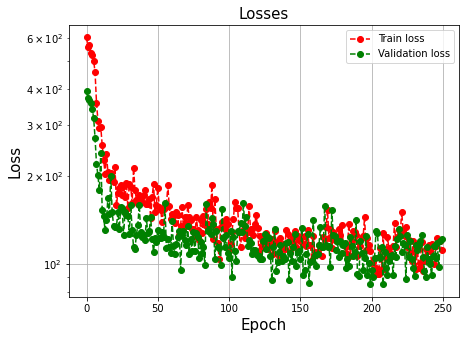

In [22]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Testing

In [26]:
# Load network parameters
model.load_state_dict(torch.load(f'Models/_lr_{learning_rate}_scale_{scale}.pth'))

<All keys matched successfully>

In [23]:
### Evaluation on test set
with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, shapes, counts = data
        inputs = inputs.to(device)
        # forward 
        outputs = model(inputs, "Test")


### Statistics on the test set

In [24]:
idx = 2
input_image = inputs.detach().cpu().numpy()[idx]
predicted_map = outputs[idx]
original_map = labels[idx]

print("Predicted map:")
print("Shape",predicted_map.shape)
print("Min", predicted_map.min())
print("Maxp",predicted_map.max())
print("")
print("Original map:")
print("Shape",original_map.shape)
print("Min",original_map.min())
print("Maxp",original_map.max())

Predicted map:
Shape torch.Size([1, 224, 224])
Min tensor(0.3630)
Maxp tensor(1.5059)

Original map:
Shape torch.Size([1, 224, 224])
Min tensor(0.)
Maxp tensor(24.5207)


Basically it is predicting all as 0 and thats why it is achieving such a low loss, so i will enlarge it to get better results.

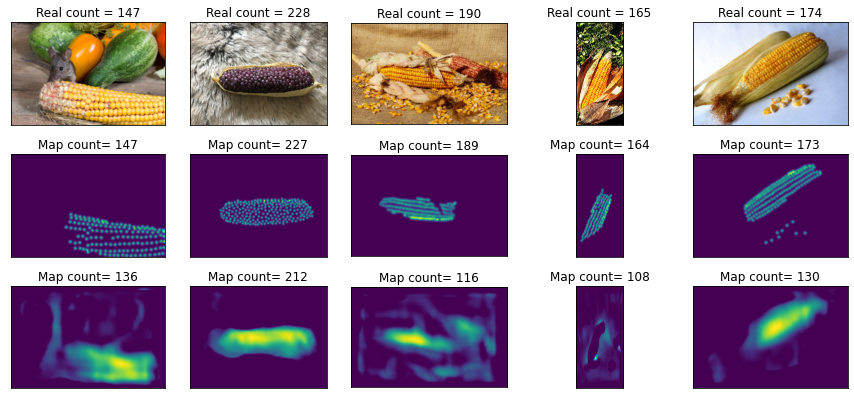

In [25]:
elements = [0,1,2,3,4]#random.sample([i for i in range(len(test_dataset))], 5)

fig, axs = plt.subplots(3, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')
    img = inputs[idx]#.numpy().transpose(1, 2, 0)
    img = img[None, :]
    img = UP(img)
    img = img[0].numpy().transpose(1, 2, 0)

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/scale)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/scale)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

### Evaluation metrics

In [26]:
label_count_list = []
map_count_list = []
for idx in [i for i in range(len(test_dataset))]:
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    label_count = int(label.sum()/scale)
    label_count_list.append(label_count)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    map_count = int(map_.sum()/scale)
    map_count_list.append(map_count)

In [27]:
mae = np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list)))/len(map_count_list)
print("MAE = ", mae)

rmse = np.sqrt(np.sum(np.abs(np.array(label_count_list)-np.array(map_count_list))**2)/len(map_count_list))
print("RMSE = ", rmse)

MAE =  122.33870967741936
RMSE =  213.81100336813896


In [40]:
labels[:,0,:,:].shape

torch.Size([62, 224, 224])

In [ ]:
def mae():
    return 